In [1]:
from __future__ import print_function

import os
import numpy as np
# import torch
# import pandas as pd
from io import StringIO
# from google.cloud import storage
import matplotlib.pyplot as plt#, mpld3
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
# Keras
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.layers import Input, Conv1D
from keras.layers.core import Dense, Dropout, Activation, Layer, Lambda, Flatten
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adadelta, adam
import random
seed = 0 #0
np.random.seed(seed=seed)
random.seed(seed)

%matplotlib inline
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../ab2.json"

Using TensorFlow backend.


In [2]:
def load_data_file(data_file, num_features):
    
    data = np.load(data_file)
    
    if data.ndim == 1:
        data = data[None, :]
    
    x = data[:, :num_features]
    y = data[:, num_features:]
    
    return x, y

In [3]:
num_features = 13
x_data, y_data = load_data_file(data_file='../train/training_hela.npy', num_features=num_features)

In [4]:
Ntr = 70000
x_data_tr = x_data[:Ntr,:]
y_data_tr = y_data[:Ntr,:]
x_data_val = x_data[Ntr:,:]
y_data_val = y_data[Ntr:,:]

In [5]:
x_range = x_data.max(0) - x_data.min(0)
y_range = y_data.max(0) - y_data.min(0)

In [6]:
# Normalise
x_data_tr = (x_data_tr - x_data.mean(0))/x_data.std(0)
x_data_val = (x_data_val - x_data.mean(0))/x_data.std(0)

y_data_tr = (y_data_tr - y_data.mean(0))/y_data.std(0)
y_data_val = (y_data_val - y_data.mean(0))/y_data.std(0)

# x_data_tr = (x_data_tr - x_data.min(0)) / ( x_range)
# x_data_val = (x_data_val - x_data.min(0)) / (x_range)

# y_data_tr = (y_data_tr - y_data.min(0)) / ( y_range)
# y_data_val = (y_data_val - y_data.min(0)) / (y_range)

In [7]:
y_data_tr

array([[ 1.46185191, -0.71861618,  0.7577628 , -0.67543539, -0.19222001],
       [ 1.00026908,  1.61576848, -1.40941168, -0.67543539,  0.87925803],
       [ 0.27815784,  0.47153331,  1.68611585, -0.67543539, -1.17297194],
       ...,
       [ 1.64867523, -1.32876152,  0.70735342, -0.67543539, -0.93628136],
       [ 1.23296519, -0.4199023 , -0.58664957, -0.67543539, -0.43405254],
       [-0.90390109, -1.27037893, -0.16190129,  0.89110287, -0.64142655]])

In [8]:
y_data[:Ntr,:]

array([[ 2.71206454e+03, -9.20361459e+00, -3.64420375e+00,
        -1.30000000e+01, -6.33353557e+00],
       [ 2.39230132e+03, -4.57762872e-01, -1.17751447e+01,
        -1.30000000e+01, -1.69429515e+00],
       [ 1.89205609e+03, -4.74467893e+00, -1.61150645e-01,
        -1.30000000e+01, -1.05799539e+01],
       ...,
       [ 2.84148709e+03, -1.14895449e+01, -3.83333284e+00,
        -1.30000000e+01, -9.55514101e+00],
       [ 2.55350242e+03, -8.08447286e+00, -8.68825429e+00,
        -1.30000000e+01, -7.38061185e+00],
       [ 1.07318038e+03, -1.12708126e+01, -7.09465710e+00,
        -6.68204828e+00, -8.27849110e+00]])

https://github.com/exoclime/HELA/blob/ffe2f0e17c86c8b593eaec4a050ec610865e36d1/example_dataset/example_dataset.json

In [9]:
names =  ["T (K)", "H2O", "HCN", "NH3", "kappa0"]
ranges =  [[0, 3000], [-13, 0], [-13, 0], [-13, 0], [-13, 0]],
colors  = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"],

In [10]:
# CNN
# x_data_tr = np.expand_dims(x_data_tr,1)
# x_data_val = np.expand_dims(x_data_val,1)

In [11]:
x_data_val.shape

(9999, 13)

In [12]:
Early_Stop_acc = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
# units
units = 1024
batch_size = 128
epochs = 100
dropout = 0.2
# Regularise
tau = 10000
lengthscale = .01
reg = lengthscale**2 * (1 - dropout) / (2. * Ntr * tau)

def network():
    model = Sequential()
    model.add(Dense(units, activation='relu', input_shape=x_data_tr.shape[1:],W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
#     model.add(Dense(y_data_tr.shape[-1], activation='relu',W_regularizer=l2(reg)))
#     model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(y_data_tr.shape[-1], activation='linear',W_regularizer=l2(reg)))
    return model

In [13]:
reg

5.714285714285715e-14

In [14]:
np.random.seed(seed=seed)
random.seed(seed)

N_ensemble = 10

### Bayes Opt

In [15]:
# def BNN_objective_init(X_train, Y_train, layers ,dropout, T, X_val, Y_val,batch_size,epochs):
 
#     def objective_function(solution):
#         start_time = time.time()
# #             solution = solution[0]
#         bnn = BNNModel(X_train, Y_train, layers , dropout, T , tau = solution[0][0], lengthscale = solution[0][1])
#         bnn.train(epochs = epochs, batch_size = batch_size, validation_data = (X_val,Y_val))
#         _, _, ll, _, _, _, _, _ , _, _, _, _  = bnn.evaluate(X_val,Y_val)
#         print(ll)
#         del bnn
#         return -np.array(ll).reshape((1,1))
#     return objective_function

# # Variables
# samples = 20 #number of samples of posterior weight distribution in BNNs
# n_iters = 10
# epochs = 50
# dropout = 0.1
# N_try = 200
# batch_size = 128
# architectures = [[1024,1024],
#                  [1024,1024,1024],
#                  [1024,1024,1024,1024]]

# tau_list = []
# lengthscale_list = []

# for layers in architectures:
#     objective_function = BNN_objective_init(X_train[:N_try], Y_train[:N_try] ,layers ,dropout, samples, X_train[N_try:], Y_train[N_try:],batch_size,epochs)
     
#     bounds = [{'name': 'tau', 'type': 'continuous',  'domain': (0.1, 10.0), 'dimensionality': 1},
#     {'name': 'lengthscale', 'type': 'continuous',  'domain': (0.001, 0.5), 'dimensionality': 1}]
#     opt_bnn = GPyOpt.methods.BayesianOptimization(objective_function, domain = bounds, batch_size=1, n_cores=1)
#     opt_bnn.run_optimization(max_iter=n_iters)
#     opt_score = max(opt_bnn.Y_best)
#     opt_score_iter = list(opt_bnn.Y_best).index(opt_score)
#     opt_solution = opt_bnn.X[opt_score_iter]
#     tau_list.append(opt_solution[0])
#     lengthscale_list.append(opt_solution[1])
#     print('done with:',layers)

In [16]:
nn_ensemble = []
training = False
if training:
    for nn in range(N_ensemble):
        np.random.seed(seed=nn)
        random.seed(nn)
        weights_file_std = '../model/HELA_weights_std.h5'
        model_checkpoint =  keras.callbacks.ModelCheckpoint(weights_file_std, monitor='val_loss', save_best_only=True,
                                           save_weights_only=True, mode='auto',verbose=0)

        std_model = network()
        std_model.compile(loss='mean_squared_error',
                          optimizer='adam')

        history_std = std_model.fit(x_data_tr, y_data_tr,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=[x_data_val,y_data_val],
                          callbacks=[model_checkpoint])
        std_model.load_weights(weights_file_std)
        nn_ensemble.append(std_model)
        print(nn, ' COMPLETED')

In [17]:
nn_ensemble = []
for n in range(N_ensemble):
    std_model = network()
    std_model.load_weights('../model/HELA_weights_std'+str(n)+'.h5')
    nn_ensemble.append(std_model)

/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, activation="relu", input_shape=(13,), kernel_regularizer=<keras.reg...)`
  
/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, activation="relu", kernel_regularizer=<keras.reg...)`
  app.launch_new_instance()
/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, activation="relu", kernel_regularizer=<keras.reg...)`
/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, activation="relu", kernel_regularizer=<keras.reg...)`
/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Up

In [14]:
# # test denorm error for min norm (2 * tanh)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_range + y_data.min(0)
# y_data_val_denorm = y_data_val * y_range + y_data.min(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# # (9999, 5)
# # [358.32918551   2.31141618   2.72354071   2.24373828   2.22574402]

In [15]:
# # test denorm error for mean norm (2 * tanh)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# # (9999, 5)
# # [348.33966495   2.28236494   2.71438089   2.16008919   2.17986165]

In [14]:
# # test denorm error for mean norm (4 * relu, 1024 units)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [335.42021214   2.25643578   2.66284313   2.10965753   2.14305779]

(9999, 5)
[335.42021214   2.25643578   2.66284313   2.10965753   2.14305779]


In [14]:
# # test denorm error for mean norm (4 * relu, 2048 units)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [337.87892212   2.29054677   2.65926488   2.0926183    2.15020789]

(9999, 5)
[337.87892212   2.29054677   2.65926488   2.0926183    2.15020789]


In [20]:
# # test denorm error for mean norm (4 * relu, units 3,2,1)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [335.37262741   2.27267598   2.65470067   2.0803818    2.15800546]

(9999, 5)
[335.37262741   2.27267598   2.65470067   2.0803818    2.15800546]


In [15]:
# # test denorm error for mean norm (4 * relu, 2048 units)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [344.86893266   2.27918209   2.67477766   2.19067704   2.18239063]

(9999, 5)
[344.86893266   2.27918209   2.67477766   2.19067704   2.18239063]


In [31]:
# # # test denorm error for mean norm (2 * tanh, 1024 units)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [342.9679369    2.27894085   2.68276775   2.14159416   2.18107573]

(9999, 5)
[342.9679369    2.27894085   2.68276775   2.14159416   2.18107573]


In [18]:
T = 10

predictions = np.zeros((N_ensemble,T,5))
n = 0
for std_model in nn_ensemble:
    predictions[n] = np.array([std_model.predict([x_data_tr[0].reshape((1,13))]) for _ in range(T)]).squeeze()
    n += 1


In [23]:
predictions = predictions.reshape((N_ensemble*T,5))

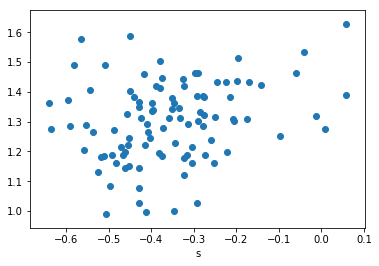

In [24]:
plt.scatter(predictions[:,1],predictions[:,0])
plt.xlabel('s')
plt.xlabel('s')
plt.show()

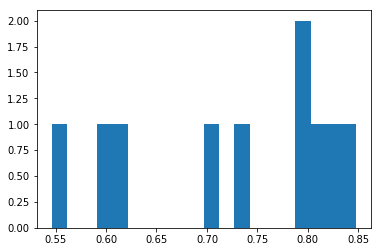

In [25]:

# plt.hist(predictions[:,0],bins=20)
plt.hist(predictions[:n,2],bins=20)
# plt.hist(predictions[:,-1],bins=20)
plt.show()

In [36]:
y_data_tr[0]

array([ 1.46185191, -0.71861618,  0.7577628 , -0.67543539, -0.19222001])

### Generate Valid Data

In [20]:
# x_data_test, y_data_test = x_data_val, y_data_val #load_data_file(data_file='../test/testing_hela.npy', num_features=num_features)

In [26]:
x_data_val.std(0)

array([1.00861155, 1.00964608, 1.01156343, 1.01069919, 1.01047562,
       1.01254634, 1.0125527 , 1.01252246, 1.01442931, 1.01421321,
       1.01352072, 1.01174974, 1.01124092])

In [27]:
T = 10

predictions_val = np.zeros((N_ensemble,T,5))
n = 0
for std_model in nn_ensemble:
    predictions_val[n] = np.array([std_model.predict([x_data_val[0].reshape((1,13))]) for _ in range(T)]).squeeze()
    print(n)
    n += 1

0
1
2
3
4
5
6
7
8
9


In [28]:
n

10

In [29]:
predictions_val = predictions_val.reshape((N_ensemble*T,5))

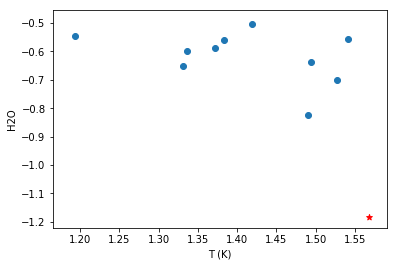

In [30]:
plt.scatter(predictions_val[:n,0],predictions_val[:n,1])
plt.scatter(y_data_val[0,0],y_data_val[0,1],color = 'r', marker = '*')
plt.xlabel(names[0])
plt.ylabel(names[1])
plt.show()

In [31]:
y_data_val[:,0]

array([ 1.56822958,  0.08094951,  0.4801466 , ...,  1.02035099,
       -0.67084713,  1.19384941])

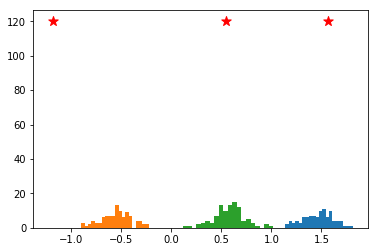

In [32]:
plt.hist(predictions_val[:,0],bins=20)
plt.hist(predictions_val[:,1],bins=20)
plt.hist(predictions_val[:,-1],bins=20)
plt.scatter([y_data_val[0,0],y_data_val[0,1],y_data_val[0,-1]],[120,120,120],color = 'red',s=100, marker = '*')
plt.show()

In [50]:
y_data_val[0]

array([ 1.56822958, -1.18232376,  1.31875397, -0.67543539,  0.54333166])

In [51]:
predictions_val[:,0]

array([1.29982305, 1.20749092, 1.50976348, 1.63125157, 1.30333877,
       1.27430844, 1.42410719, 1.42530942, 1.27405977, 1.20302403,
       1.32910252, 1.17617679, 1.3884697 , 1.50139761, 1.34875965,
       1.59610581, 1.26666284, 1.56383753, 1.34007955, 1.30229473,
       1.39912224, 1.29602718, 1.59117889, 1.43419766, 1.60701489,
       1.33454752, 1.27638626, 1.25650907, 1.64536285, 1.35310125,
       1.36785638, 1.33504283, 1.2601161 , 1.31704342, 1.35721135,
       1.40108228, 1.28933728, 1.27445316, 1.25971746, 1.29813957,
       1.43170774, 1.61691046, 1.18271494, 1.41572404, 1.47557425,
       1.40782356, 1.44932604, 1.42326653, 1.14793921, 1.0942812 ,
       1.34549832, 1.19639277, 1.34181786, 1.30471778, 1.56978655,
       1.48507786, 1.24814844, 1.22196937, 1.17405319, 1.25819492,
       1.39219213, 1.56043839, 1.54593492, 1.61886787, 1.52578211,
       1.46288228, 1.42980099, 1.29714119, 1.20618939, 1.3426193 ,
       1.34801865, 1.35570383, 1.31980848, 1.25649071, 1.26648

In [18]:
No_pred = 1000
T=10
PRED = np.zeros((No_pred,N_ensemble,T,5))
n = 0
for std_model in nn_ensemble:
    for planet in range(No_pred):
        PRED[planet,n] = np.array([std_model.predict(x_data_val[planet,:].reshape((1,13))) for _ in range(T)]).squeeze()
    # predictions_test = pipeline.trees_predict(np.array(x_data_test)[0,:])
    print(n,' models completed')
    n += 1

0  models completed
1  models completed
2  models completed
3  models completed
4  models completed
5  models completed
6  models completed
7  models completed
8  models completed
9  models completed


In [19]:
PRED.shape

(1000, 10, 10, 5)

In [20]:
PRED_o = PRED[:]

In [21]:
PRED = PRED_o[:,:n].reshape((No_pred,-1,y_data_val.shape[-1]))

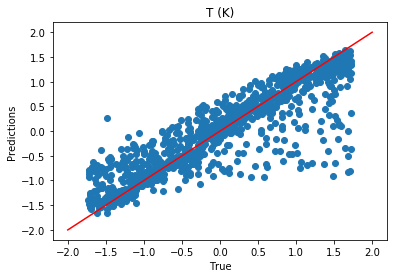

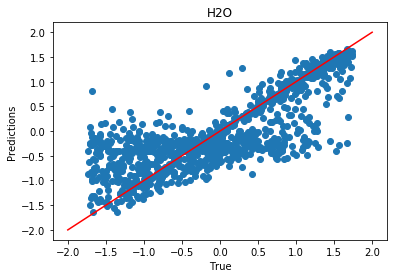

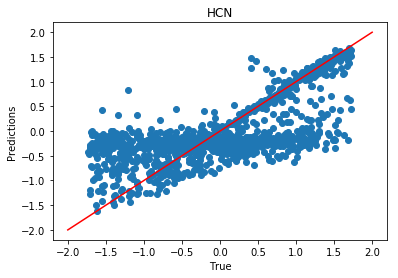

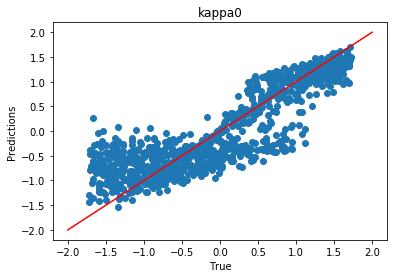

In [22]:
yyy = [-2,2]
for mol in range(5):
    plt.title(names[mol])
    plt.ylabel('Predictions')
    plt.xlabel('True')
    plt.scatter(y_data_val[:No_pred,mol],PRED.mean(1)[:,mol])
    plt.plot(yyy,yyy,'r')
#     plt.savefig('../valid/'+names[mol]+'pred_vs_true.png')
    plt.show()

In [23]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn import metrics, neighbors
from sklearn.preprocessing import MinMaxScaler


def predicted_vs_real(y_real, y_pred, names, ranges):
    
    num_plots = y_pred.shape[1]
    num_plot_rows = int(np.sqrt(num_plots))
    num_plot_cols = (num_plots - 1) // num_plot_rows + 1
    
    fig, axes = plt.subplots(num_plot_rows, num_plot_cols,
                             figsize=(5*num_plot_cols, 5*num_plot_rows))
    
    for dim, (ax, name_i, range_i) in enumerate(zip(axes.ravel(), names, ranges)):
        
        current_real = y_real[:, dim]
        current_pred = y_pred[:, dim]
        
        r2 = metrics.r2_score(current_real, current_pred)
        label = "$R^2 = {:.3f}$".format(r2)
        ax.plot(current_real, current_pred, '.', label=label)
        
        ax.plot(range_i, range_i, '--', linewidth=3, color="C3")
        
        ax.axis("equal")
        ax.grid()
        ax.set_xlim(range_i)
        ax.set_ylim(range_i)
        ax.set_xlabel("Real {}".format(name_i), fontsize=18)
        ax.set_ylabel("Predicted {}".format(name_i), fontsize=18)
        ax.legend(loc="upper left", fontsize=14)
    
    fig.tight_layout()
    return fig


def feature_importances(forests, names, colors):
    
    num_plots = len(forests)
    num_plot_rows = (num_plots - 1) // 2 + 1
    num_plot_cols = 2
    
    fig, axes = plt.subplots(num_plot_rows, num_plot_cols,
                             figsize=(15, 3.5*num_plot_rows))
    
    for ax, forest_i, name_i, color_i in zip(axes.ravel(), forests, names, colors):
        ax.bar(np.arange(len(forest_i.feature_importances_)), forest_i.feature_importances_,
               label="Importance for {}".format(name_i),
               width=0.4, color=color_i)
        ax.set_xlabel("Feature index", fontsize=18)
        ax.legend(fontsize=16)
        ax.grid()
    
    fig.tight_layout()
    return fig


def posterior_matrix(estimations, y, names, ranges, colors, soft_colors=None):
    
    cmaps = [LinearSegmentedColormap.from_list("MyReds", [(1, 1, 1), c], N=256)
             for c in colors]
    
    ranges = np.array(ranges)
    
    if soft_colors is None:
        soft_colors = colors
    
    num_dims = estimations.shape[1]
    
    fig, axes = plt.subplots(nrows=num_dims, ncols=num_dims,
                             figsize=(2 * num_dims, 2 * num_dims))
    fig.subplots_adjust(left=0.07, right=1-0.05,
                        bottom=0.07, top=1-0.05,
                        hspace=0.05, wspace=0.05)
    
    for ax, dims in zip(axes.flat, product(range(num_dims), range(num_dims))):
        dims = list(dims[::-1])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.title.set_visible(False)
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
            ax.yaxis.set_visible(True)
            if names is not None:
                ax.set_ylabel(names[dims[1]], fontsize=18)
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
            ax.yaxis.set_visible(True)
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
            ax.xaxis.set_visible(True)
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')
            ax.xaxis.set_visible(True)
            if names is not None:
                ax.set_xlabel(names[dims[0]], fontsize=18)
        if ax.is_first_col() and ax.is_first_row():
            ax.yaxis.set_visible(False)
            ax.set_ylabel("")
        if ax.is_last_col() and ax.is_last_row():
            ax.yaxis.set_visible(False)
        
        if dims[0] < dims[1]:
            locations, kd_probs, *_ = _kernel_density_joint(estimations[:, dims], ranges[dims])
            ax.contour(locations[0], locations[1],
                       kd_probs,
                       colors=colors[dims[0]],
                       linewidths=0.5
                       # 'copper', # 'hot', 'magma' ('copper' with white background)
                      )
            histogram, grid_x, grid_y = _histogram(estimations[:, dims], ranges[dims])
            ax.pcolormesh(grid_x, grid_y, histogram, cmap=cmaps[dims[0]])
            
            expected = np.median(estimations[:, dims], axis=0)
            ax.plot([expected[0], expected[0]], [ranges[dims[1]][0], ranges[dims[1]][1]], '-', linewidth=1, color='#222222')
            ax.plot([ranges[dims[0]][0], ranges[dims[0]][1]], [expected[1], expected[1]], '-', linewidth=1, color='#222222')
            ax.plot(expected[0], expected[1], '.', color='#222222')
            ax.axis('normal')
            if y is not None:
                real = y[dims]
                ax.plot(real[0], real[1], '*', markersize=10, color='#FF0000')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        elif dims[0] > dims[1]:
            ax.plot(estimations[:, dims[0]], estimations[:, dims[1]], '.', color=soft_colors[dims[1]])
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        else:
            histogram, bins = _histogram(estimations[:, dims[:1]], ranges=ranges[dims[:1]])
            ax.bar(bins[:-1], histogram, color=soft_colors[dims[0]], width=bins[1]-bins[0])
            
            kd_probs = histogram
            expected = np.median(estimations[:, dims[0]])
            ax.plot([expected, expected], [0, 1.1 * kd_probs.max()], '-', linewidth=1, color='#222222')
            
            if y is not None:
                real = y[dims[0]]
                ax.plot([real, real], [0, kd_probs.max()], 'r-')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     0, 1.1 * kd_probs.max()])
    
    # fig.tight_layout(pad=0)
    return fig


def _min_max_scaler(ranges, feature_range=(0, 100)):
    res = MinMaxScaler()
    res.data_max_ = ranges[:, 1]
    res.data_min_ = ranges[:, 0]
    res.data_range_ = res.data_max_ - res.data_min_
    res.scale_ = (feature_range[1] - feature_range[0]) / (ranges[:, 1] - ranges[:, 0])
    res.min_ = -res.scale_ * res.data_min_
    res.n_samples_seen_ = 1
    res.feature_range = feature_range
    return res


def _kernel_density_joint(estimations, ranges, bandwidth=1/25):
    
    ndims = len(ranges)
    
    scaler = _min_max_scaler(ranges, feature_range=(0, 100))
    
    bandwidth = bandwidth * 100
    # step = 1.0
    
    kd = neighbors.KernelDensity(bandwidth=bandwidth).fit(scaler.transform(estimations))
    locations1d = np.arange(0, 100, 1)
    locations = np.reshape(np.meshgrid(*[locations1d] * ndims), (ndims, -1)).T
    kd_probs = np.exp(kd.score_samples(locations))
    
    shape = (ndims,) + (len(locations1d),) * ndims
    locations = scaler.inverse_transform(locations)
    locations = np.reshape(locations.T, shape)
    kd_probs = np.reshape(kd_probs, shape[1:])
    return locations, kd_probs, kd


def _histogram(estimations, ranges, bins=20):
    
    if len(ranges) == 1:
        histogram, edges = np.histogram(estimations[:, 0], bins=bins, range=ranges[0])
        return histogram, edges
    
    if len(ranges) == 2:
        histogram, xedges, yedges = np.histogram2d(estimations[:, 0], estimations[:, 1], bins=bins, range=ranges)
        grid_x, grid_y = np.meshgrid(xedges, yedges)
        return histogram.T, grid_x, grid_y, 

In [24]:
# un-normalise
PRED_un = PRED * y_data.std(0) +y_data.mean(0)
y_data_val_un = y_data_val * y_data.std(0) +y_data.mean(0)

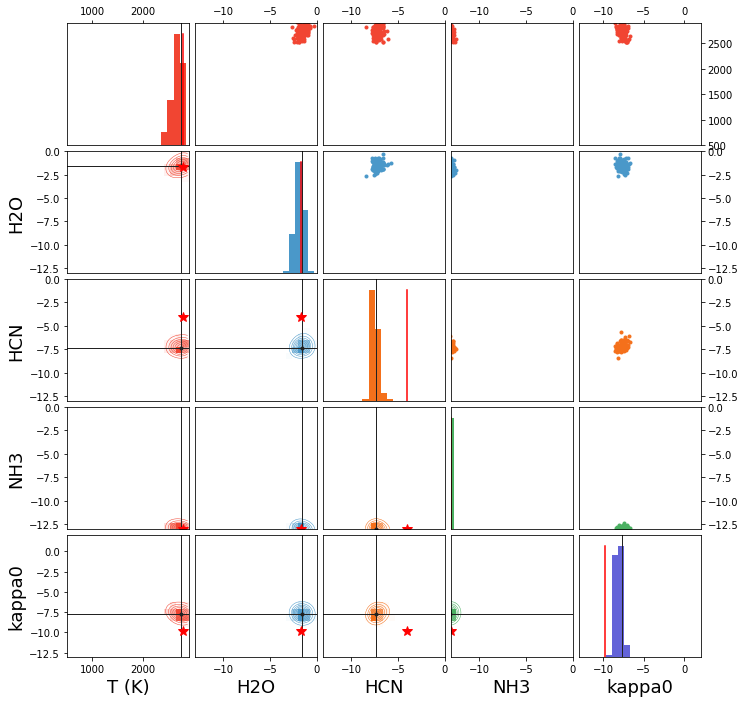

In [32]:
planet_id = 999
num_features = 5
# delta = 0.05
ranges=[[x, y] for x, y in zip(y_data_val_un.min(0), y_data_val_un.max(0))]
# [[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, 1],[0, 1]]
names =  ["T (K)", "H2O", "HCN", "NH3", "kappa0"]
colors = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"]#, "#F14532", "#4a98c9", "#f4701b", 
#           "#4bb062", "#6363d8","#4bb062", "#6363d8","#4a98c9", "#f4701b"]
posterior_matrix(PRED_un[planet_id,:,:num_features], y_data_val_un[planet_id,:num_features], names, ranges, colors, soft_colors=None)
# plt.savefig('../figures/NN10_ensemble_planet_id'+str(planet_id + Ntr)+'.pdf')
plt.show()

In [42]:
PRED_un = PRED * y_data.std(0) +y_data.mean(0)

In [43]:
y_data_val_un = y_data_val * y_data.std(0) +y_data.mean(0)

In [44]:
y_data_val_un - y_data[Ntr:,:]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])